In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [7]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/media/yu-hao/WindowsData/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

2.64 -2.117904
(228, 906, 3)


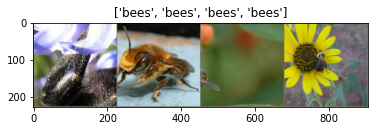

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    print(np.max(inp.flatten()), np.min(inp.flatten()))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    print(inp.shape)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [13]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [17]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/yu-hao/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [18]:
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

In [ ]:
visualize_model(model_ft)


In [65]:
from pathlib import Path

import ast

import pandas as pd

# df = pd.read_csv('/media/yu-hao/WindowsData/WheatDataset/train.csv')
# #df.head()

# df['bbox'] = df['bbox'].apply(lambda x: np.array(x))
# x = np.array(list(df['bbox']))
# print(x)
# for i, dim in enumerate(['x', 'y', 'w', 'h']):
#     df[dim] = x[:, i]

# df.drop('bbox', axis=1, inplace=True)
#df.head()

class WheatDataset(torch.utils.data.Dataset):
    def __init__(self, df, image_dir, transforms = None):
        super().__init__()
        
        self.df = df
        self.image_ids  = self.df['image_id'].unique()
        self.image_dir  = Path(image_dir)
        self.transforms = transforms
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        records  = self.df[self.df['image_id'] == image_id]
        
        im_name = image_id + '.jpg'
        img = Image.open(self.image_dir/im_name).convert("RGB")
        img = T.ToTensor()(img)
        
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0]+boxes[:, 2]
        boxes[:, 3] = boxes[:, 1]+boxes[:, 3]
        #print('boxes shape is ',boxes.shape)
        boxes = torch.Tensor(boxes).to(device)#, device='cuda:0')#dtype=torch.int64)
        
        labels = torch.ones((records.shape[0], ), dtype=torch.int64)
        
        target = {}
        target['boxes']  = boxes
        target['labels'] = labels
        target['image_id']  = torch.tensor([idx])
        
        return img, target, image_id
    
    def __len__(self):
        return self.image_ids.shape[0]

class DBTDataset(torch.utils.data.Dataset):
    def __init__(self, transforms = None):
        super().__init__()
        
        self.trainx = np.load('/media/yu-hao/WindowsData/DBT_numpy/trainx.npy').astype('float16')/60000.0
        self.trainy = np.load('/media/yu-hao/WindowsData/DBT_numpy/trainy.npy')
        self.coordx = np.load('/media/yu-hao/WindowsData/DBT_numpy/coordx.npy')
        self.coordy = np.load('/media/yu-hao/WindowsData/DBT_numpy/coordy.npy')
        self.width_arr  = np.load('/media/yu-hao/WindowsData/DBT_numpy/width_arr.npy')
        self.height_arr = np.load('/media/yu-hao/WindowsData/DBT_numpy/height_arr.npy')
        
        self.transforms = transforms
    
    def __getitem__(self, idx):
        img = self.trainx[idx, 0]
        print(img.shape, 'img shape is')
        img = T.ToTensor()(img)
        
        boxes = np.array([self.coordx[idx], self.coordy[idx], self.width_arr[idx], self.height_arr[idx]])#records[['x', 'y', 'w', 'h']].values
        print(boxes)
        boxes[2] = boxes[0]+boxes[2]
        boxes[3] = boxes[1]+boxes[3]
        boxes = [boxes]
        #print('boxes shape is ',boxes.shape)
        boxes = torch.Tensor(boxes).to(device)#, device='cuda:0')#dtype=torch.int64)
        
        labels = torch.Tensor(self.trainy[idx]).to(device)
        
        target = {}
        target['boxes']     = boxes
        target['labels']    = labels
        target['image_id']  = torch.tensor([idx])
        
        return img, target, idx
    
    def __len__(self):
        return self.trainx.shape[0]

In [66]:
#td1 = WheatDataset(df, '/media/yu-hao/WindowsData/WheatDataset/train/')
td1 = DBTDataset()

(3000, 2000) img shape is
[1446  796  353  417]


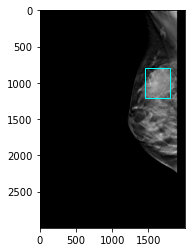

In [78]:
import matplotlib.patches as patches
import random

from torchvision import  transforms as T

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from PIL import Image

index = random.randint(0, len(td1)-1)
a, b, c = td1[index]
temp  = b['boxes'].data.cpu().numpy()
index = random.randint(0, len(temp)-1)

#print(temp)

im    = a.data.cpu().numpy()
plt.imshow(im[0].astype('float32'), cmap='gray')

ax   = plt.gca()


index = 0
rect = patches.Rectangle((temp[index][0], temp[index][1]), temp[index][2]-temp[index][0], temp[index][3]-temp[index][1], linewidth=1, edgecolor='cyan', fill = False)
#rect = patches.Rectangle((temp[index][1], temp[index][0]), temp[index][3]-temp[index][1], temp[index][2]-temp[index][0], linewidth=1, edgecolor='cyan', fill = False)
ax.add_patch(rect)
#rect = patches.Rectangle((0, 0), 500, 100, linewidth=2, edgecolor='cyan', fill = False)


plt.show()

In [64]:
print(len(td1))

AttributeError: 'DBTDataset' object has no attribute 'image_ids'